In [1]:
import dgl
from dgl.data import DGLDataset
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
from dgl.nn import GraphConv,MaxPooling
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import time
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import os

from torchviz import make_dot
from IPython.display import display
%matplotlib inline

In [2]:
class STL10TrainDataset(DGLDataset):
    def __init__(self,data_path,transforms=None):
        self.data_path = data_path
        self.transforms = transforms
        super().__init__(name='stl10_train_gprah')
    
    def process(self):
        GRAPHS, LABELS = dgl.load_graphs(self.data_path) #保存したグラーフデータの読み込み
        self.graphs = GRAPHS #グラフリストを代入
        self.labels = LABELS['label'] #ラベル辞書の値のみ代入
        self.dim_nfeats=len(self.graphs[0].ndata['feat'][0])

    def __getitem__(self, idx):
        if self.transforms == None:
            return self.graphs[idx], self.labels[idx]
        else:
            data=self.transforms(self.graphs[idx])
            return data,self.labels[idx]
    def __len__(self):
        return len(self.graphs)


class STL10TestDataset(DGLDataset):
    def __init__(self,data_path,transforms=None):
        self.data_path = data_path
        self.transforms = transforms
        super().__init__(name='stl10_test_gprah')
    
    def process(self):
        GRAPHS, LABELS = dgl.load_graphs(self.data_path) #保存したグラーフデータの読み込み
        self.graphs = GRAPHS #グラフリストを代入
        self.labels = LABELS['label'] #ラベル辞書の値のみ代入
        self.dim_nfeats=len(self.graphs[0].ndata['feat'][0])

    def __getitem__(self, idx):
        if self.transforms == None:
            return self.graphs[idx], self.labels[idx]
        else:
            data=self.transforms(self.graphs[idx])
            return data,self.labels[idx]
        
    def __len__(self):
        return len(self.graphs)

In [3]:
#transform = transforms.Compose([transforms.Normalize(0,1)])
traindataset=STL10TrainDataset('../data/STL10 Datasets/train/nnum100_ndatades_enone.dgl')
testdataset=STL10TestDataset('../data/STL10 Datasets/test/nnum100_ndatades_enone.dgl')

In [4]:
if os.name =='posix':
    num_workers = 2
else:
    num_workers = 0
num_workers = 0
traindataloader = GraphDataLoader(traindataset,batch_size = 50,shuffle = True,num_workers = num_workers,pin_memory = True)
testdataloader = GraphDataLoader(testdataset,batch_size = 1000,shuffle = True,num_workers = num_workers,pin_memory = True)
print(f'num_wokers = {num_workers}')
print(os.name)

num_wokers = 0
posix


In [5]:
class GCN(nn.Module):
    def __init__(self,in_feat,h_feat,num_classes):
        super(GCN,self).__init__()
        self.gconv1=GraphConv(in_feat,h_feat)
        self.gconv2=GraphConv(h_feat,h_feat)

        self.gconv3=GraphConv(h_feat,num_classes)
        self.gconv4=GraphConv(h_feat,num_classes)

        self.dropout=nn.Dropout(0.2)

    def forward(self,g,in_feat):
        #x=in_feat.detach()

        h=F.relu(self.gconv1(g,in_feat))
        h=F.relu(self.gconv2(g,h))
        h=self.dropout(h)
    
        #h=h+x

        h=self.gconv3(g,h)
        #h=F.relu(self.gconv4(g,h))
        
        g.ndata['h'] = h
        return dgl.mean_nodes(g,'h')

In [5]:
class ligcn_block(nn.Module):
    def __init__(self,in_feat,h_feat):
        super(ligcn_block,self).__init__()
        self.liner1=nn.Linear(in_feat,h_feat)
        self.gcn=GraphConv(h_feat,h_feat)
        self.liner2=nn.Linear(h_feat,h_feat)
    
    def forward(self,g,in_feat):
        x=F.relu(self.liner1(in_feat))
        x=F.relu(self.gcn(g,x))
        x=F.relu(self.liner2(x))

        return x


class GCN_rc(nn.Module):
    def __init__(self,in_feat,h_feat,num_classes):
        super(GCN_rc,self).__init__()
        self.b1=ligcn_block(in_feat,in_feat)
        self.b2=ligcn_block(in_feat,h_feat)
        self.b3=ligcn_block(h_feat,h_feat)
        self.b4=ligcn_block(h_feat,h_feat)
        self.b5=ligcn_block(h_feat,num_classes)

    def forward(self,g,in_feat):
        x=in_feat

        h=F.relu(self.b1(g,in_feat))
        h=h+x
        
        h=F.relu(self.b2(g,h))
        y=h

        h=F.relu(self.b3(g,h))
        h=h+y

        h=F.relu(self.b4(g,h))
        h=F.relu(self.b5(g,h))

        g.ndata['h'] = h

        return dgl.mean_nodes(g,'h')


In [6]:
print(traindataset.dim_nfeats)
model=GCN_rc(traindataset.dim_nfeats,300,10)
optimizer=optim.Adam(model.parameters(),lr=0.0001)
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
epochs=500

61


In [7]:
save_train_acc = []
save_test_acc = []

In [8]:
loss_list = []
acc_list = []
test_acc_list = []


num_correct = 0
num_tests = 0
test_num_correct = 0
test_num_tests = 0
lossF = nn.CrossEntropyLoss()
#,batched_graph.edata['distance'].float()
BP = 0
for epoch in tqdm(range(epochs)):
    if BP != 0:
        break
    model.train()
    for batched_graph, labels in traindataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat'].float()/255)
        loss = lossF(pred,labels)
        if loss.item() < 0.05:
            BP = 0
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    loss_list.append(loss.item())
    acc_list.append(num_correct / num_tests) #学習中トレーニングacc
    
    model.eval()
    for tbatched_graph, tlabels in testdataloader:
        tbatched_graph = tbatched_graph.to(device)
        tlabels = tlabels.to(device)
        tpred = model(tbatched_graph, tbatched_graph.ndata['feat'].float()/255)
        test_num_correct += (tpred.argmax(1) == tlabels).sum().item()
        test_num_tests += len(tlabels)

    Tacc = test_num_correct / test_num_tests
    #print('Training accuracy:', Tacc)
    test_acc_list.append(Tacc) #学習中テストacc


100%|██████████| 500/500 [32:47<00:00,  3.94s/it]


In [9]:
num_correct = 0
num_tests = 0



with torch.no_grad():
    model.train()
    for batched_graph, labels in traindataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat'].float()/255)
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    print('Training accuracy:', num_correct / num_tests)
    save_train_acc.append(num_correct / num_tests)
    num_correct = 0
    num_tests = 0
    model.eval()
    for batched_graph, labels in testdataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat'].float()/255)
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    print('Test accuracy:', num_correct / num_tests)
    save_test_acc.append(num_correct / num_tests)

Training accuracy: 0.7168
Test accuracy: 0.2490622655663916


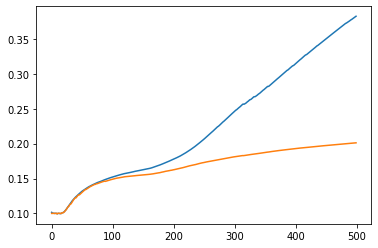

In [10]:
x=[i for i in range(len(acc_list))]
y_train=acc_list
y_test=test_acc_list
plt.plot(x,y_train)
plt.plot(x,y_test)

plt.show()

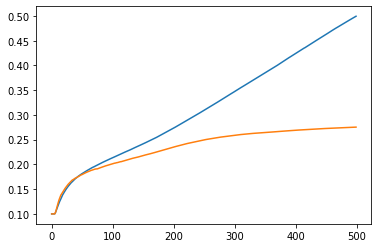

In [100]:
x=[i for i in range(len(acc_list))]
y_train=acc_list
y_test=test_acc_list
plt.plot(x,y_train)
plt.plot(x,y_test)

plt.show()

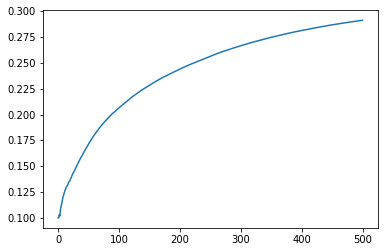

In [93]:
plt.plot(x,test_acc_list)

plt.show()

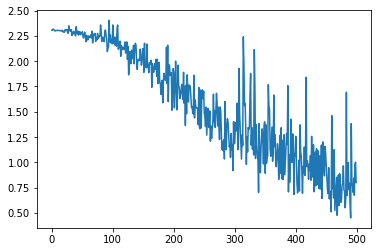

In [11]:
plt.plot(x,loss_list)
plt.show()

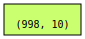

In [50]:
img=make_dot(pred,params=dict(model.named_parameters()))
display(img)

In [27]:
model

GCN_rc(
  (b1): ligcn_block(
    (liner1): Linear(in_features=61, out_features=61, bias=True)
    (gcn): GraphConv(in=61, out=61, normalization=both, activation=None)
    (liner2): Linear(in_features=61, out_features=61, bias=True)
  )
  (b2): ligcn_block(
    (liner1): Linear(in_features=61, out_features=30, bias=True)
    (gcn): GraphConv(in=30, out=30, normalization=both, activation=None)
    (liner2): Linear(in_features=30, out_features=30, bias=True)
  )
  (b3): ligcn_block(
    (liner1): Linear(in_features=30, out_features=10, bias=True)
    (gcn): GraphConv(in=10, out=10, normalization=both, activation=None)
    (liner2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [6]:
clay=[20,30,40,80,180,320]
epochs=500
save_train_acc = []
save_test_acc = []
save_train_acc_list=[]
save_test_acc_list=[]
for i in clay:
    model=GCN(traindataset.dim_nfeats,i,10)
    optimizer=optim.Adam(model.parameters(),lr=0.001)
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)


    loss_list = []
    acc_list = []
    test_acc_list = []


    num_correct = 0
    num_tests = 0
    test_num_correct = 0
    test_num_tests = 0
    lossF = nn.CrossEntropyLoss()
    #,batched_graph.edata['distance'].float()
    BP = 0
    for epoch in tqdm(range(epochs)):
        if BP != 0:
            break
        model.train()
        for batched_graph, labels in traindataloader:
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)
            pred = model(batched_graph, batched_graph.ndata['feat'].float()/255)
            loss = lossF(pred,labels)
            if loss.item() < 0.05:
                BP = 0
                break
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            num_correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)
        loss_list.append(loss.item())
        acc_list.append(num_correct / num_tests) #学習中トレーニングacc
    
        model.eval()
        for tbatched_graph, tlabels in testdataloader:
            tbatched_graph = tbatched_graph.to(device)
            tlabels = tlabels.to(device)
            tpred = model(tbatched_graph, tbatched_graph.ndata['feat'].float()/255)
            test_num_correct += (tpred.argmax(1) == tlabels).sum().item()
            test_num_tests += len(tlabels)

        Tacc = test_num_correct / test_num_tests
        #print('Training accuracy:', Tacc)
        test_acc_list.append(Tacc) #学習中テストacc

    save_train_acc_list.append(acc_list)
    save_test_acc_list.append(test_acc_list)
    num_correct = 0
    num_tests = 0

    class_corrent=np.zeros(10)
    class_total=np.zeros(10)



    with torch.no_grad():
        model.train()
        for batched_graph, labels in traindataloader:
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)
            pred = model(batched_graph, batched_graph.ndata['feat'].float()/255)
            num_correct += (pred.argmax(1) == labels).sum().item()

            _,predicted=torch.max(pred,1)
            c=(predicted == labels).squeeze()
            for j in range(50):
                label=labels[j]
                class_corrent[label] += c[j].item()
                class_total[label] +=1

            
            num_tests += len(labels)
        print('Training accuracy:', num_correct / num_tests)
        save_train_acc.append(num_correct / num_tests)
        print(f'Train h_node:{i} class acc')
        for k in range(10):
            print(f'class {k} : {100*class_corrent[k]/class_total[k]}')
        np.save(f'train{i}class_corrent',class_corrent)
        np.save(f'train{i}class_total',class_total)

        num_correct = 0
        num_tests = 0
        class_corrent=np.zeros(10)
        class_total=np.zeros(10)
        
        model.eval()
        for batched_graph, labels in testdataloader:
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)
            pred = model(batched_graph, batched_graph.ndata['feat'].float()/255)
            num_correct += (pred.argmax(1) == labels).sum().item()

            _,predicted=torch.max(pred,1)
            c=(predicted == labels).squeeze()
            for j in range(labels.shape[0]):
                label=labels[j]
                class_corrent[label] += c[j].item()
                class_total[label] +=1

            num_tests += len(labels)
        print('Test accuracy:', num_correct / num_tests)
        save_test_acc.append(num_correct / num_tests)
        print(f'Test h_node:{i} class acc')
        for k in range(10):
            print(f'class {k} : {100*class_corrent[k]/class_total[k]}')
        np.save(f'test{i}class_corrent',class_corrent)
        np.save(f'test{i}class_total',class_total)

100%|██████████| 500/500 [18:13<00:00,  2.19s/it]


Training accuracy: 0.3372
Train h_node:20 class acc
class 0 : 47.2
class 1 : 9.0
class 2 : 26.6
class 3 : 32.4
class 4 : 53.0
class 5 : 30.8
class 6 : 34.8
class 7 : 16.2
class 8 : 58.8
class 9 : 28.4
Test accuracy: 0.30120030007501875
Test h_node:20 class acc
class 0 : 39.75
class 1 : 8.125
class 2 : 23.5
class 3 : 27.53441802252816
class 4 : 49.75
class 5 : 24.75
class 6 : 33.75
class 7 : 13.875
class 8 : 52.19023779724656
class 9 : 28.0


100%|██████████| 500/500 [18:14<00:00,  2.19s/it]


Training accuracy: 0.338
Train h_node:30 class acc
class 0 : 41.6
class 1 : 12.2
class 2 : 57.6
class 3 : 41.0
class 4 : 29.4
class 5 : 26.2
class 6 : 27.6
class 7 : 22.2
class 8 : 45.6
class 9 : 34.6
Test accuracy: 0.2989497374343586
Test h_node:30 class acc
class 0 : 36.625
class 1 : 9.875
class 2 : 48.75
class 3 : 36.67083854818523
class 4 : 25.75
class 5 : 24.25
class 6 : 25.125
class 7 : 19.25
class 8 : 38.54818523153943
class 9 : 34.125


100%|██████████| 500/500 [18:21<00:00,  2.20s/it]


Training accuracy: 0.3836
Train h_node:40 class acc
class 0 : 58.0
class 1 : 25.2
class 2 : 43.4
class 3 : 36.6
class 4 : 44.2
class 5 : 29.4
class 6 : 30.6
class 7 : 27.4
class 8 : 53.6
class 9 : 35.2
Test accuracy: 0.3010752688172043
Test h_node:40 class acc
class 0 : 46.0
class 1 : 17.875
class 2 : 35.0
class 3 : 30.037546933667084
class 4 : 36.375
class 5 : 20.75
class 6 : 24.5
class 7 : 17.75
class 8 : 42.67834793491865
class 9 : 30.125


100%|██████████| 500/500 [17:48<00:00,  2.14s/it]


Training accuracy: 0.505
Train h_node:80 class acc
class 0 : 70.2
class 1 : 31.0
class 2 : 64.4
class 3 : 57.0
class 4 : 51.2
class 5 : 54.4
class 6 : 51.2
class 7 : 39.0
class 8 : 50.4
class 9 : 36.2
Test accuracy: 0.2754438609652413
Test h_node:80 class acc
class 0 : 38.25
class 1 : 9.5
class 2 : 39.875
class 3 : 33.917396745932415
class 4 : 30.875
class 5 : 22.625
class 6 : 29.5
class 7 : 17.125
class 8 : 31.1639549436796
class 9 : 22.625


100%|██████████| 500/500 [18:24<00:00,  2.21s/it]


Training accuracy: 0.724
Train h_node:180 class acc
class 0 : 85.4
class 1 : 66.6
class 2 : 68.8
class 3 : 64.0
class 4 : 68.2
class 5 : 77.2
class 6 : 67.6
class 7 : 61.6
class 8 : 79.2
class 9 : 85.4
Test accuracy: 0.2571892973243311
Test h_node:180 class acc
class 0 : 33.625
class 1 : 13.375
class 2 : 27.75
class 3 : 24.780976220275345
class 4 : 19.875
class 5 : 24.375
class 6 : 22.0
class 7 : 14.875
class 8 : 38.54818523153943
class 9 : 38.0


100%|██████████| 500/500 [19:00<00:00,  2.28s/it]


Training accuracy: 0.943
Train h_node:320 class acc
class 0 : 98.0
class 1 : 89.0
class 2 : 92.2
class 3 : 94.0
class 4 : 91.2
class 5 : 92.8
class 6 : 95.8
class 7 : 97.8
class 8 : 97.2
class 9 : 95.0
Test accuracy: 0.24856214053513379
Test h_node:320 class acc
class 0 : 33.0
class 1 : 12.0
class 2 : 25.0
class 3 : 26.408010012515646
class 4 : 22.375
class 5 : 18.25
class 6 : 24.125
class 7 : 22.0
class 8 : 37.6720901126408
class 9 : 27.75


In [14]:
print(save_train_acc)
print(save_test_acc)

[0.1672, 0.1838]
[0.16616654163540887, 0.17641910477619405]


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

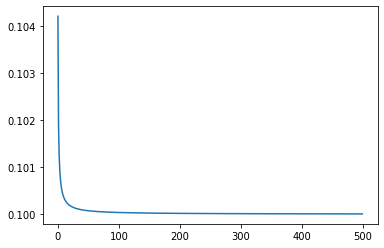

In [18]:
plt.plot(range(epochs),save_train_acc_list[3])
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

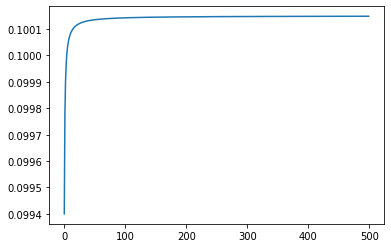

In [19]:
plt.plot(range(epochs),save_test_acc_list[3])
plt.plot

In [8]:
print(len(save_train_acc_list[0]))

500


In [8]:
np.save('trainacc_2lay_20304080180320',save_train_acc_list)

In [9]:
np.save('testacc_2lay_20304080180320',save_test_acc_list)